# Задание №2. Деинтерлейсинг

## Описание

Задание разделено на 2 большие части:

### 1. Эвристический алгоритм

Реализовать эвристический алгоритм деинтерлейсинга, основанный на любых алгоритмах, расказанных (и не расказанных) на лекции.

**Требования**:
* работает не дольше 1 FPS
* использует _только_ те пакеты, которые указаны в файле `requirements.txt`

### 2. Нейросетевой алгоритм

Реализовать нейросетевой алгоритм деинтерлейсинга.

**Требования**:
* модель реализована на фреймворке TensorFlow / Keras
* обучение происходило _только_ на предоставленной обучающей выборке (но можно использовать разумное размножение выборки)

### Общие требования

* соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны.

## Оценивание

1. Каждый участник может представить не более 1 эвристического алгоритма и не более 1 нейросетевого алгоритма для финального   тестирования

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 10) тестовых видео

3. В качестве метрик будут использованы:
    * PSNR
    * SSIM
    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место каждого алгоритма определяется по формуле: $Place_{algo} = \frac{Place_{PSNR} + Place_{SSIM}}{2}$

6. Баллы за конкретный алгоритм зависят от его места: $Score_{algo} = score(Place_{algo})$

7. Баллы участника складываются из баллов за эвристический алгоритм и нейросетевой алгоритм: $Score_{stud} = Score_{heuristic}^{stud} + Score_{neural}^{stud}$

8. Если какой-либо алгоритм не представлен студентом или не выполнены _требования_ — это эквивалентно обнулению соответствующего значения: $Score_{algo}^{stud} = 0$

## Повторение

* [Статья на Хабре](https://habr.com/en/post/51201/) про развёртки
* [Статья на Хабре](https://habr.com/en/post/61822/) про методы деинтерлейсинга

_Прогрессивная развёртка (построчная развёртка)_ — способ трансляции и хранения видео, при котором в каждом кадре все строки отображаются последовательно.

_Интерлейсинг (чересстрочная развёртка)_ — способ трансляции и хранения видео, при котором каждый кадр разбивается на два поля (чётное и нечётное).

<img src="extra/interlacing-scheme.gif" width="300"/>

* _Top Field (Odd Field, чётное поле)_ — чётные строки кадра
* _Bottom Field (Even Field, нечётное поле)_ — нечётные строки кадра

То, какое поле (чётное или нечётное) отвечает за более ранний момент времени — настраиваемый параметр. Обычно чётное поле по времени не позже нечётного

При интерлейсинге:
* частота кадров *увеличивается в 2 раза* относительно исходного видео в прогрессивной развёртке
* разрешение каждого отдельного кадра *уменьшается в 2 раза*

Это происходит из-за того, что в каждый момент времени на экране отображается только один полукадр.

![interlaced-vs-progressive](extra/interlaced-vs-progressive.jpg)

_Деинтерлейсинг_ — преобразование из чересстрочной развёртки в прогрессивную без потери частоты кадров.

## Часть 1. Эвристический деинтерлейсер

Скачайте тестовые данные отсюда: https://titan.gml-team.ru:5003/sharing/W3xvJLC2D

Устанавка всего необходимого

In [1]:
# pip install -r requirements.txt

Необходимые импорты

In [8]:
import cv2                       # Библиотека компьютерного зрения OpenCV.
import matplotlib.pyplot as plt  # Пакет PyPlot для визуализаций и графиков.
import numpy as np               # Библиотека вычислений NumPy.
import os                        # Часть стандартной библиотеки Python, отвечает за системные вызовы.
import skimage.metrics
from tqdm.notebook import tqdm

from measure import (
    measure_single               # Эта функция замеряет качество для одного видео по нескольким метрикам.
)

from utils import (
    read_sequence,               # Функция для чтения кадров видео из указанной папки.
    save_image_png,              # Функция для сохранения картинки без сжатия, в формате PNG.
    save_image_jpg,              # Функция для сохранения картинки со сжатием, в формате JPEG.
    extract_fields,              # Функция для извлечения последовательных полей из чересстрочного видео.
    rgb2gray
)

# Устанавливаем размер графиков в более приемлимый для просмотра
plt.rcParams['figure.figsize'] = (15.0, 10.0)

# Папка с видео в чересстрочной развёртке.
INTERLACE_VIDEO_DIR = '../data/interlace/'

# Папка с теми же видео в прогрессивной развёртке.
# GT_VIDEO_DIR = '../data/gt/'
GT_VIDEO_DIR = '../data/gt/'

### Бэйзлайн: алгоритм Bob
В качестве отправной точки возьмём простейший алгоритм Bob.

Краткое напоминание о том, как он работает:
\begin{equation}
  Pixel_k(x, y) = \begin{cases}
    Pixel_k(x, y), & \text{if $y + k = 0$ mod $2$},\\
    \frac{Pixel_k(x, y - 1) + Pixel_k(x, y + 1)}{2}, & \text{otherwise}.
  \end{cases}
\end{equation}
где $k$ — номер кадра в чересстрочной видеопоследовательности.

In [9]:
def deinterlace_bob(fields, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    # Выделяем память под все итоговые кадры
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    for index, field in enumerate(tqdm(fields)):
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            
            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:
                if field_row <= 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    deinterlaced[index, row] = \
                        np.rint(field[field_row] / 2 + field[field_row + 1] / 2).astype('uint8')
                    
    return deinterlaced

### Проверка работоспособности

#### 1. Считываем чересстрочное видео с помощью функции `read_sequence`:

In [10]:
interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, '04')
interlaced = read_sequence(interlaced_video_folder)

Первое, что мы должны проверить — размерность полученного тензора.

Он представляет собой видео в формате NHWC, где:
* N — кол-во кадров
* H — высота
* W — ширина
* С — число каналов, для цветного изображения C = 3

In [11]:
interlaced.shape

(50, 360, 640, 3)

Теперь посмотрим, _что_ мы считали. Для этого распечатаем первый кадр с помощью функции `plt.imshow`:

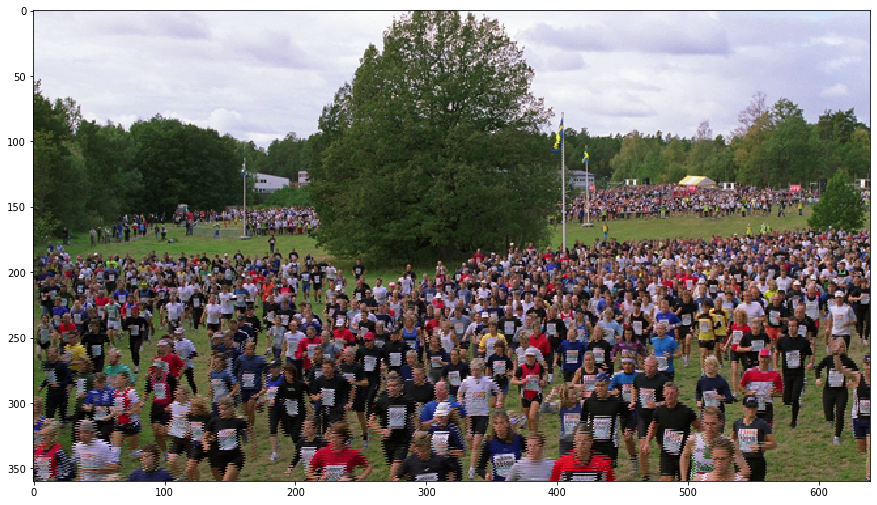

In [13]:
plt.imshow(interlaced[1])

#### 2. Извлекаем последовательные поля из чересстрочного видео:

In [14]:
fields = extract_fields(interlaced)

In [15]:
fields.shape

(100, 180, 640, 3)

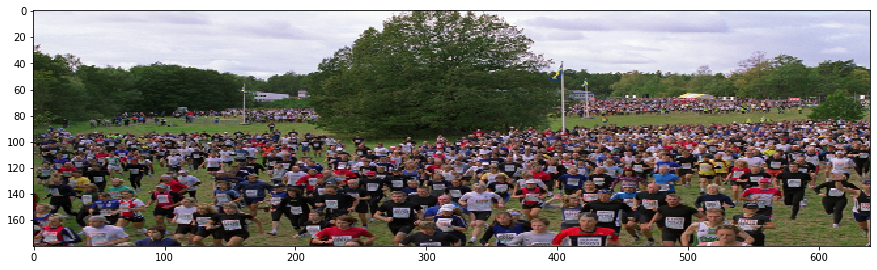

In [16]:
plt.imshow(fields[0])

#### 3. Применяем, наконец, наш алгоритм Bob к последовательным полям:

In [17]:
deinterlaced = deinterlace_bob(fields)

In [18]:
deinterlaced.shape

(100, 360, 640, 3)

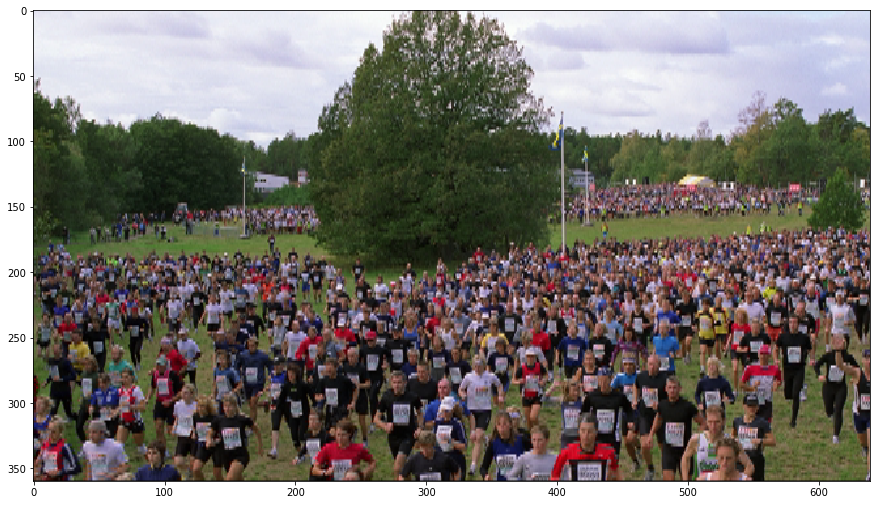

In [19]:
plt.imshow(deinterlaced[0])

### Измерение качества: PSNR, SSIM

* [Peak Signal-to-Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Structural_similarity)
* [Structural Similarity (SSIM)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)

PSNR и SSIM — full-reference метрики. Это означает, что для их измерения необходимо иметь GT (ground-truth, исходные данные). Помимо full-reference бывают no-reference метрики, не требующие GT.

В нашем случае GT — это видео в progressive-развёртке, из которого было получено interlace-видео искусственным образом.

Считываем GT-видео:

In [20]:
gt_video_folder = os.path.join(GT_VIDEO_DIR, '04')
gt_video = read_sequence(gt_video_folder)

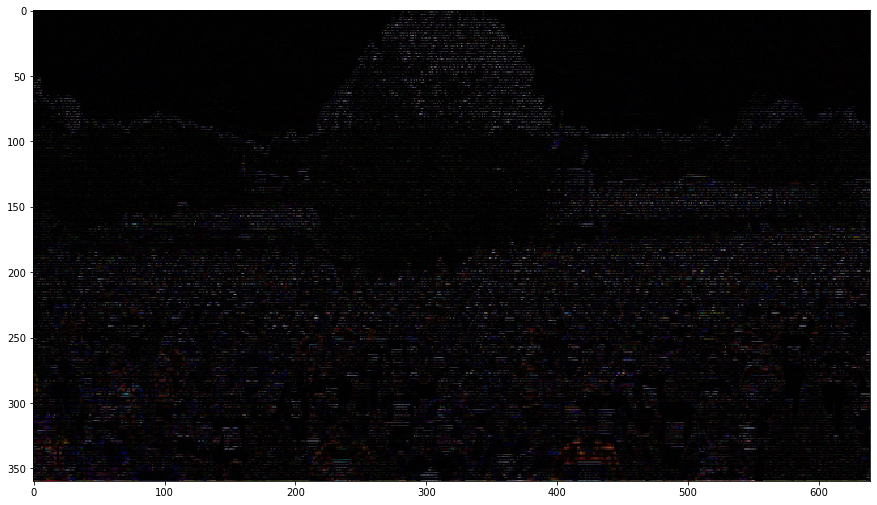

In [21]:
plt.imshow(np.abs(gt_video[0].astype('int16') - deinterlaced[0].astype('int16')))

Вычислим PSNR и SSIM, выдаваемые нашим Bob'ом.

_Замечание_: Вычисление SSIM по целому видео занимает продолжительное время (~10 мин.)

In [22]:
def _psnr(first, second):
    return skimage.metrics.peak_signal_noise_ratio(first, second)

def _ssim(first, second):
    return skimage.metrics.structural_similarity(first, second, multichannel=True)

In [39]:
for i in tqdm(range(10), leave=False):
    metrics = {
        'psnr': _psnr,
        'ssim': _ssim
    }
    gt_video_folder = os.path.join(GT_VIDEO_DIR, f'0{i}')
    gt_video = read_sequence(gt_video_folder)
    interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, f'0{i}')
    interlaced = read_sequence(interlaced_video_folder)
    fields = extract_fields(interlaced)
    metric_values = measure_single(fields, gt_video, deinterlace_bob, metrics)
    print(metric_values)


{'psnr': {'mean': 27.152261821822673, 'std': 1.6744812661850579}, 'ssim': {'mean': 0.8736204827395848, 'std': 0.010277961151777317}}



{'psnr': {'mean': 24.49574619078391, 'std': 1.9427276645168483}, 'ssim': {'mean': 0.8802962111984115, 'std': 0.013615657074392287}}



{'psnr': {'mean': 29.279849564512936, 'std': 1.5187611781301524}, 'ssim': {'mean': 0.899901910902167, 'std': 0.005658734526762008}}



{'psnr': {'mean': 26.555625855022235, 'std': 1.4103656997747014}, 'ssim': {'mean': 0.8408813773508668, 'std': 0.030026695490479465}}



{'psnr': {'mean': 25.956209657097407, 'std': 0.4294135179752884}, 'ssim': {'mean': 0.89644371915808, 'std': 0.0017297162722749075}}



{'psnr': {'mean': 22.49601290266396, 'std': 0.27415026443067153}, 'ssim': {'mean': 0.7007682373725378, 'std': 0.010709993390478257}}



{'psnr': {'mean': 30.574875283735523, 'std': 0.31769358462190744}, 'ssim': {'mean': 0.9644608268272796, 'std': 0.0013853347700779452}}



{'psnr': {'mean': 28.53478179616131, 'std': 0.8867102163729272}, 'ssim': {'mean': 0.8979193973174721, 'std': 0.0018068556538180353}}



{'psnr': {'mean': 25.855556101043394, 'std': 1.0191316653970408}, 'ssim': {'mean': 0.852677026840814, 'std': 0.01860213860048825}}



{'psnr': {'mean': 24.358396740329635, 'std': 1.5416152879141674}, 'ssim': {'mean': 0.8115811680762728, 'std': 0.03351410452773673}}


In [60]:
def my_deinterlace_bob(fields, sig_s = 100, sig_c = 100, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    # Выделяем память под все итоговые кадры
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    for index, field in enumerate(tqdm(fields)):
        field = cv2.cvtColor(field, cv2.COLOR_BGR2YUV)
        field = field.astype('int16')
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            
            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:                         
                if field_row <= 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    for chan in range(3):                   
                        for x in range(width):
                            f_ij = (field[field_row - 1, x, chan] + field[field_row + 1, x, chan]) / 2
                            if x <= 0 or x == width - 1:
                                deinterlaced[index, field_row, x, chan] = f_ij.astype('uint8')
                            else:
                                b = np.ones(6) * (-1 / (2 * sig_c ** 2))
                                a = np.ones(6) * (-1 / (2 * sig_s ** 2))
                                f = np.zeros(6)
                                f[0] = field[field_row - 1, x - 1, chan]
                                f[1] = field[field_row - 1, x, chan]
                                f[2] = field[field_row - 1, x + 1, chan]
                                f[3] = field[field_row + 1, x - 1, chan]
                                f[4] = field[field_row + 1, x, chan]
                                f[5] = field[field_row + 1, x + 1, chan]
                                b[0] *= (field_row - 1) ** 2 + (x - 1)**2
                                b[1] *= (field_row - 1) ** 2 + (x)**2
                                b[2] *= (field_row - 1) ** 2 + (x + 1)**2
                                b[3] *= (field_row + 1) ** 2 + (x - 1)**2
                                b[4] *= (field_row + 1) ** 2 + (x)**2
                                b[5] *= (field_row + 1) ** 2 + (x + 1)**2
                                a[0] *= (f_ij - field[field_row - 1, x - 1, chan]) ** 2
                                a[1] *= (f_ij - field[field_row - 1, x, chan]) ** 2
                                a[2] *= (f_ij - field[field_row - 1, x + 1, chan]) ** 2
                                a[3] *= (f_ij - field[field_row + 1, x - 1, chan]) ** 2
                                a[4] *= (f_ij - field[field_row + 1, x, chan]) ** 2
                                a[5] *= (f_ij - field[field_row + 1, x + 1, chan]) ** 2
                                deinterlaced[index, field_row, x, chan] = (np.sum(a * b * f) / np.sum(a * b)).astype('uint8')                            
                    
        deinterlaced[index] = cv2.cvtColor(deinterlaced[index], cv2.COLOR_YUV2BGR)
    return deinterlaced

In [61]:
for i in tqdm(range(10)):
    metrics = {
        'psnr': _psnr,
        'ssim': _ssim
    }
    gt_video_folder = os.path.join(GT_VIDEO_DIR, f'0{i}')
    gt_video = read_sequence(gt_video_folder)
    interlaced_video_folder = os.path.join(INTERLACE_VIDEO_DIR, f'0{i}')
    interlaced = read_sequence(interlaced_video_folder)
    fields = extract_fields(interlaced)
    metric_values = measure_single(fields, gt_video, my_deinterlace_bob, metrics)
    print(metric_values)

/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [24]:
metric_values

{'psnr': {'mean': 25.956209657097407, 'std': 0.4294135179752884},
 'ssim': {'mean': 0.89644371915808, 'std': 0.0017297162722749075}}

Теперь ваша задача — максимально улучшить этот результат!

In [25]:
fields[0].shape

(180, 640, 3)

### Работа с Optical Flow

Определим вспомогательные функции для интерполяции промежуточного кадра. Для вычисления оптического потока будем пользоваться модулем `cv2`

In [42]:
def warp_image(image, flow, interpolation=cv2.INTER_LANCZOS4):
    mid_flow = -flow / 2
    
    height, width = image.shape[:2]
    map_x = np.ones((height, 1)).dot(np.arange(width).reshape((1, width))) + mid_flow[:,:,0]
    map_y = np.ones((width, 1)).dot(np.arange(height).reshape((1, height))).T + mid_flow[:,:,1]
    
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)
    
    return cv2.remap(image, map_x, map_y, interpolation)

In [43]:
def compute_flow(current_frame, next_frame):
    current_frame = cv2.cvtColor(current_frame, cv2.COLOR_RGB2GRAY)
    next_frame = cv2.cvtColor(next_frame, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        current_frame, next_frame, flow=None, 
        pyr_scale=0.5, levels=5, winsize=15, 
        iterations=5, poly_n=5, poly_sigma=0.5, 
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    
    return flow

In [44]:
def interpolate_frames(frames):
    frames = np.array(frames, dtype=np.float32)  # OpenCV может не поддерживать float64
    prev_frame = frames[0]
    interpolated_frames = []
    
    for cur_frame in frames[1:]:
        flow = compute_flow(prev_frame, cur_frame)
        intermediate_frame = warp_image(prev_frame, flow.astype(np.float32))
        interpolated_frames.append(intermediate_frame)
        prev_frame = cur_frame
        
    return np.array(interpolated_frames)

Теперь можно пользоваться функцией `interpolate_frames()` для того, чтобы интерполировать поля

In [45]:
interpolated = interpolate_frames(fields[:3:2] / 255.)

In [46]:
image = np.zeros(interlaced.shape[1:], dtype=np.uint8)

In [47]:
image[::2] = np.rint(interpolated[0] * 255.).astype(np.uint8)
image[1::2] = fields[1]

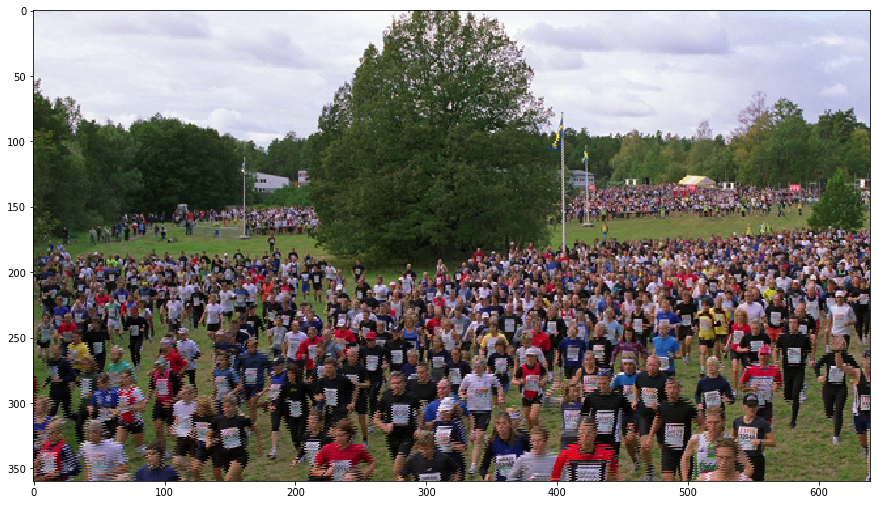

In [48]:
plt.imshow(image)

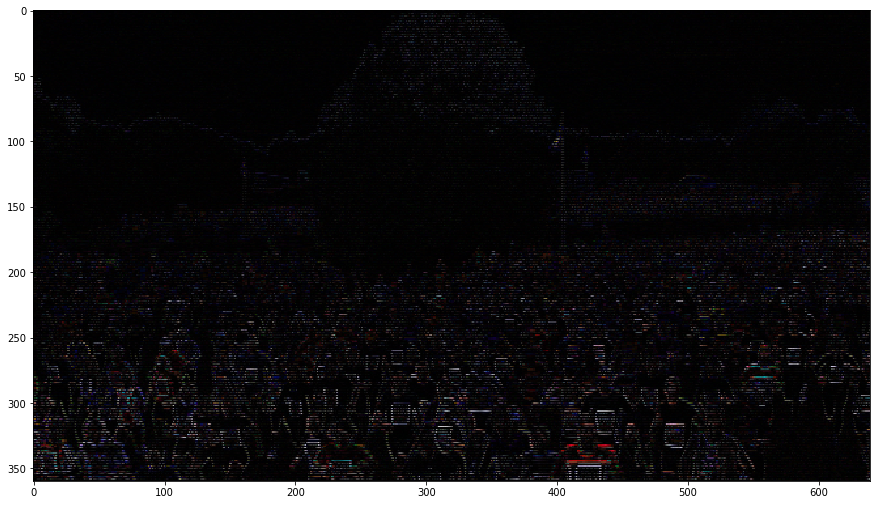

In [49]:
plt.imshow(np.abs(gt_video[1].astype('int16') - image.astype('int16')))

### Your Code

Рекомендуем начать с простого алгоритма, добиться его работоспособности и приемлемого качества, а затем итеративно усложнять модель и подбирать параметры. Не забывайте тестироваться на разных видео из датасета :)

Следующие функции могут оказаться полезными:
* `cv2.calcOpticalFlowFarneback` — вычисляет Optical Flow (подробнее: [док](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af), [туториал](https://docs.opencv.org/3.4/d7/d8b/tutorial_py_lucas_kanade.html))

Правила сдачи задания:
 - Комментарий `# GRADED FUNCTION: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри функции `deinterlace_video`.

In [1]:
# GRADED FUNCTION: deinterlace_video

def deinterlace_video(fields, top_frame_first=True):
    num_frames, height, width, num_channels = fields.shape
    # Выделяем память под все итоговые кадры
    deinterlaced = np.zeros((num_frames, height * 2, width, num_channels), dtype='uint8')
    
    for index, field in enumerate(tqdm(fields)):
        for row in range(height * 2):
            residual = (row + index) % 2
            field_row = (row - residual) // 2
            
            if (top_frame_first and residual == 0) or (not top_frame_first and residual == 1):
                deinterlaced[index, row] = field[field_row]
            else:
                if field_row <= 0:
                    # Важно приводить к uint8
                    deinterlaced[index, row] = (field[0] / 2).astype('uint8')
                elif field_row + 1 >= height:
                    deinterlaced[index, row] = (field[-1] / 2).astype('uint8')
                else:
                    deinterlaced[index, row] = \
                        np.rint(field[field_row] / 2 + field[field_row + 1] / 2).astype('uint8')
                    
    return deinterlaced

Протестируем ваш алгоритм.

In [ ]:
metric_values = measure_single(fields, gt_video, deinterlace_video, metrics)
metric_values

## В следующей серии...

## Часть 2. Нейросетевой деинтерлейсер

...